<a href="https://colab.research.google.com/github/lgpatruyo/Heart-Condition-Classification/blob/main/XGB_Rebal_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modules

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [ ]:
# Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# Collecting Data

In [ ]:
# IMPORTING DATA WITH NO HEART CONDITION (NORMAL) FROM MY DRIVE
df_normal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_normal.csv', header=None)

In [ ]:
# IMPORTING DATA WITH HEART CONDITION (ABNORMAL) FROM MY DRIVE
df_abnormal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_abnormal.csv', header=None)

In [ ]:
df_abnormal.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)

In [ ]:
X_data = df.loc[:,:186]
y_data = df.loc[:,187]

# Preliminary ECG Visuals

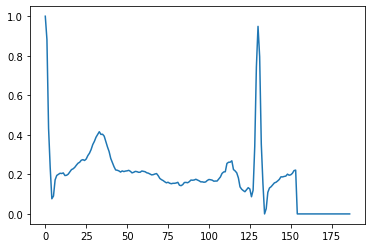

In [ ]:
#Normal ECG
plt.plot(X_data.loc[100,:])

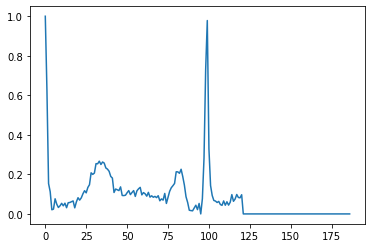

In [ ]:
#Abnormal ECG
plt.plot(X_data.loc[6000,:])

In [ ]:
y_data.value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

# Splitting Data & Setting "y" Categorical

In [ ]:
dfX_train, dfX_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, train_size=0.8, random_state = 42)

In [ ]:
y_train

4292     1.0
8963     1.0
10671    1.0
8994     1.0
13691    1.0
        ... 
5191     1.0
13418    1.0
5390     1.0
860      0.0
7270     1.0
Name: 187, Length: 11641, dtype: float64

In [ ]:
#Preparing the train dataset including "y" before balancing the classes.
df_train = pd.concat([dfX_train, pd.Series(y_train)], axis=1)

In [ ]:
df_train[187].value_counts()

1.0    8429
0.0    3212
Name: 187, dtype: int64

In [ ]:
y_test.value_counts()

1.0    2077
0.0     834
Name: 187, dtype: int64

# Balancing Classes in Train Set

In [ ]:
from sklearn.utils import resample

df_0=(df_train[df_train[187]==0])
df_1=(df_train[df_train[187]==1]).sample(n=8400,random_state=42)

#resampling minority class with replacement
df_0_upsample=resample(df_0,replace=True,n_samples=8400,random_state=123)

#balanced df
df_train_balanced=pd.concat([df_0_upsample,df_1])

#shuffling rows in balanced df
df_train_shuffled=df_train_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_shuffled[187].value_counts()

0.0    8400
1.0    8400
Name: 187, dtype: int64

In [ ]:
X_train_proc = df_train_shuffled.iloc[:,:187]
y_train_proc = df_train_shuffled.iloc[:,187]

In [ ]:
X_train_proc.shape

(16800, 187)

In [ ]:
y_train_proc.shape

(16800,)

# XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

classifier = xgb.XGBClassifier(random_state=42)
#parameter information: (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
#Copied from Kaggle (https://www.kaggle.com/phunter/xgboost-with-gridsearchcv)
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
param_grid = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              #'num_class': [2],
              #'learning_rate': [0.3], #so called `eta` value
              'max_depth': [6, 8 , 10],
              #'min_child_weight': [10], #Higher values minimize overfitting, default = 1
              #'silent': [0],
              #'subsample': [0.8], #Lower values (more conservative) prevents overfitting but too small values lead to under-fitting.
                                  #Typical values: 0.5-1
              #'colsample_bytree': [0.7],
              'n_estimators': [100, 500], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
              }

xgb_grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
xgb_grid.fit(X_train_proc, y_train_proc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'n_estimators': [100, 500],
                         'objective': ['binary:logistic']},
             pre_dispatch='2*n_jobs', re

In [ ]:
model_xgb = xgb_grid.best_estimator_  # Sklearn automatically retrains the model on the whole 
                                      # training set following cross-validation using the best hyperparameters
#pred_prob = model_xgb.predict_proba(X_test)
xgb_grid.best_params_

{'max_depth': 8, 'n_estimators': 500, 'objective': 'binary:logistic'}

In [ ]:
y_pred = model_xgb.predict(dfX_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9807626245276537

In [ ]:
#
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


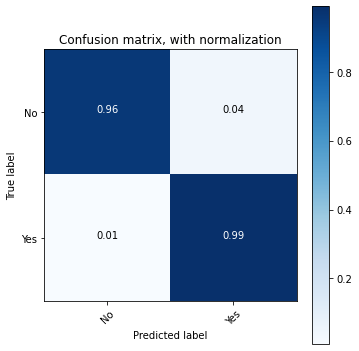

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'Yes'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

          No       0.98      0.96      0.97       834
         Yes       0.98      0.99      0.99      2077

    accuracy                           0.98      2911
   macro avg       0.98      0.97      0.98      2911
weighted avg       0.98      0.98      0.98      2911

